In [2]:
# load essential packages
import os
import matplotlib.pyplot as plt
import numpy as np
import modules.functions as fs
from dataclasses import dataclass
from vxtools.summarize.structure import SummaryFile
from sklearn.metrics import auc
from scipy.stats import pearsonr
from modules.dataloader import all_rois
from modules.plotstyle import PlotStyle

ps = PlotStyle()

/home/weygoldt/Data/uni/neuro_gp/calciumimaging/testcode/modules/functions.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Importing the data

To filter all ROIs for the ones that reacted to our stimulus, we first have to load the data.

In [3]:
# now load the data
f = SummaryFile('../data/Summary.hdf5')

# now select the recordings that were good
good_recs = [5, 8, 9, 10, 11, 13, 14]#
# good_recs = [5, 14]

# load matrix of all rois of all layers with good rois
d = all_rois(f, good_recs)

[ roimatrix.__init__ ] Loading data ...:   0%|          | 0/7 [00:00<?, ?it/s]

As described in the [loading_data](loading_data.qmd) notebook, we can now compute the means for all dff time series in each stimulation window.

In [4]:
datapath = "../data/"
dataname = "mean_dffs.npy"
timename = "mean_times.npy"

if os.path.exists(datapath+dataname) == False:
    d.stimulus_means()
    np.save(datapath+dataname, d.mean_dffs)
    np.save(datapath+timename, d.mean_times)
else:
    d.mean_dffs = np.load(datapath+dataname)
    d.mean_times = np.load(datapath+timename)

## Computing autocorrelation

Now we can compute the autocorrelation of each time series to quantify how well a cell (i.e. a single ROI) responds to the stimulation - and sort the ROIs by their correlation coefficient.

In [5]:
d.sort_means_by_corr()

[ roimatrix.sort_means_by_corr ] Computing autocorrelation for every dff ...:   0%|          | 0/…

Now that we have the correlation coefficients, we can sort all ROIs in out dataset (i.e. all dffs) by their correlation coefficient.

In [6]:
#d.mean_dffs = np.array([d.mean_dffs[int(roi)] for roi in d.corrs[:,0]])

## Thresholding the autocorrelation

We use the means for each stimulation phase since the temporal resolution is not needed at this point and it is much easier to work with the means.

Before we threshold the autocorrelation, we look at a distribution of them by computing a histogram and estimate the probability density function using a gaussian kernel.

In [7]:
# make a histpgram
counts, edges = np.histogram(d.corrs[:, 1], bins=50, density=True)

# compute a gaussian KDE
xkde, kde = fs.kde1d(d.corrs[:, 1], 0.02, xlims=[edges.min(), edges.max()])

computed AreaUnderCurve (AUC) of KDE using sklearn.metrics.auc: 0.9992113307761934


Now we plot the results.

Text(0, 0.5, 'Probability density')

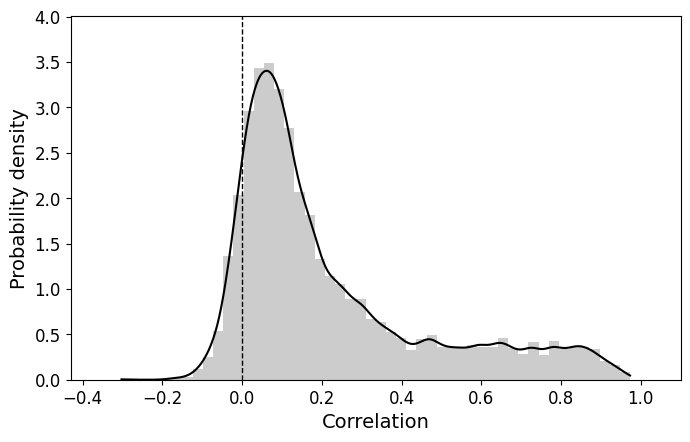

In [8]:
#| code-fold: true
fig, ax = plt.subplots(figsize=(20*ps.cm, 12*ps.cm))
ax.bar(edges[:-1], counts, width=np.diff(edges),edgecolor="white", facecolor="k", alpha=0.2,linewidth=0, align="edge", zorder=20)
ax.plot(xkde, kde, zorder=10, c="k")
ax.axvline([0], lw=1, ls="dashed", c="k")
ax.set_xlabel("Correlation")
ax.set_ylabel("Probability density")

Instead of implementing a fixed correlation coefficient as a threshold, we can instead use an integral of the proabability density function, to get the correlation coefficients that occur with a probability of $\alpha = 0.05$ or less.

Since we are only insterested in strong positive correlations, we can integrate (compute the area under curve, the AUC)between a value on the x axis and the maximum correlation coefficient.

In [9]:
target_auc = 0.2 # probability threshold

# create empty arrays for the gradient and index
gradient = np.zeros_like(xkde[:-1])
index = np.arange(len(xkde[:-1]))

# compute the gradient between the target and actual auc
for i in range(len(xkde[:-1])):
    area = auc(xkde[i:], kde[i:])
    gradient[i] = abs(area-target_auc)

# find the index where the gradient is smallest
idx = index[gradient == gradient.min()][0]

Text(0.5, 0.01, 'Spearman correlation')

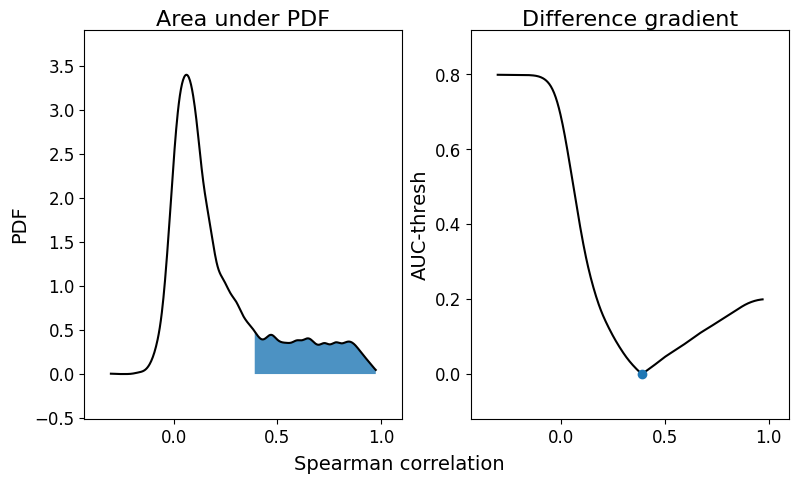

In [10]:
#| code-fold: true
# plot the gradient
fig, ax = plt.subplots(1,2,figsize=(20*ps.cm, 12*ps.cm), constrained_layout=True)
ax[0].plot(xkde, kde, c="k")
ax[0].fill_between(xkde[idx:], np.zeros_like(xkde[idx:]), kde[idx:], zorder=-10, alpha=0.8)
ax[0].set_title("Area under PDF")
ax[0].set_ylabel("PDF")
ax[1].plot(xkde[:-1], gradient, c="k")
ax[1].scatter(xkde[idx], gradient[idx], zorder=10)
ax[1].set_title("Difference gradient")
ax[1].set_ylabel("AUC-thresh")
fig.supxlabel("Spearman correlation", fontsize=14)

The correlation threshold is now the value on the x-axis at the computed index.

In [11]:
thresh = xkde[idx]

Now we can use this value to threshold the correlations and return the dffs for the "active" ROIs. 

Before we do this, we first compute the means for a single time series across trials. This is the data which we will continue to use to narrow down a cells selectivity. Using the means across repeats emphasized correlated activity and smoothes randomness.

In a next step, we get the dffs for these ROIs.

In [12]:
# get the rois
d.thresh_mean_rois = fs.thresh_correlations(d.corrs, thresh)

# compute mean across trials
d.repeat_means()

# get the phase and repeat mean dffs
d.active_meanmean_dffs = np.array([d.meanstack_mean_dffs[int(roi), :] for roi in d.thresh_mean_rois[:,0]])

# get the phase mean dff
d.active_mean_dffs = np.array([d.mean_dffs[int(roi), :] for roi in d.thresh_mean_rois[:,0]])

# get their rois as well
d.active_mean_rois = np.array([d.index_rois[int(roi)] for roi in d.thresh_mean_rois[:,0]])

# ... and the recording they came from
d.active_mean_recs = np.array([d.index_recs[int(roi)] for roi in d.thresh_mean_rois[:,0]])


[ roimatrix.repeat_means ] Computing means across repeats...


Now lets plot a raster plot of our thresholded data.

Text(0, 0.5, 'ROI')

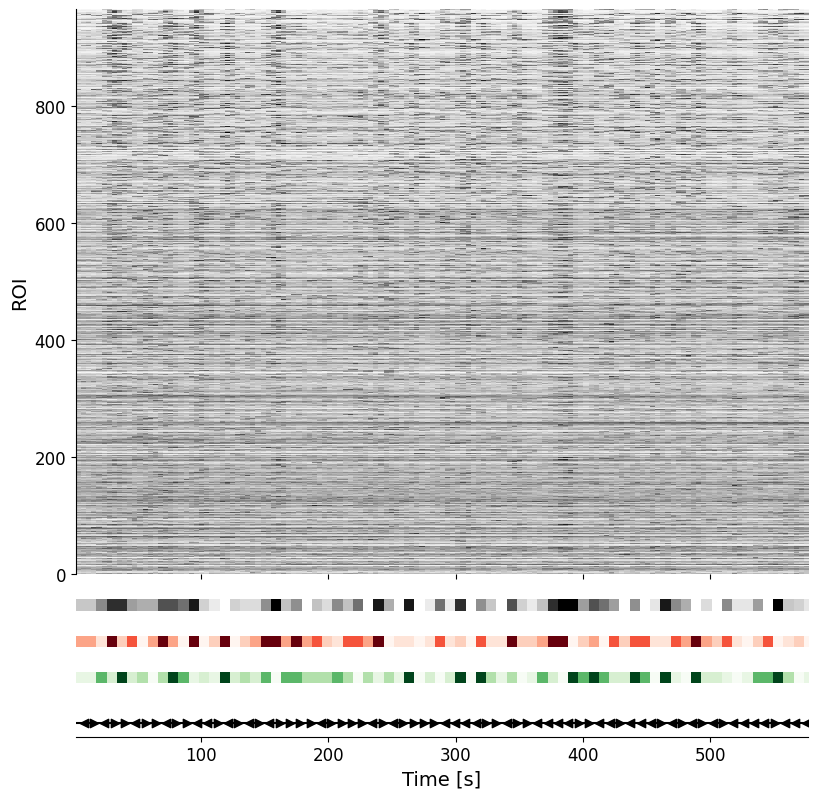

In [13]:
#| code-fold: true

# take only first repeat
idx = np.arange(d.inx_mean[0][0], d.inx_mean[0][1])

# encode the stimulus

# luminance contrast: max(all)_stripe1 - max(all)_stripe2
stripe1 = np.array([np.max(x) for x in d.rgb_1])
stripe2 = np.array([np.max(x) for x in d.rgb_2])
lum_contr = abs(stripe1-stripe2)[d.inx_mean[0][0]:d.inx_mean[0][1]]

# color contrast: red_stripe1 - red_stripe2 (for red and green)
red = np.array(
    [abs(x[0]-y[0]) for x, y in zip(d.rgb_1, d.rgb_2)]
)[d.inx_mean[0][0]:d.inx_mean[0][1]]

reds = np.empty((len(d.active_meanmean_dffs[:, 0]), len(red)))
for i in range(len(reds[:, 0])):
    reds[i, :] = red

green = np.array(
    [abs(x[1]-y[1]) for x, y in zip(d.rgb_1, d.rgb_2)]
)[d.inx_mean[0][0]:d.inx_mean[0][1]]

greens = np.empty((len(d.active_meanmean_dffs[:, 0]), len(green)))
for i in range(len(greens[:, 0])):
    greens[i, :] = green

# make no rot = 0, counterclock = -1, clockwise = 1
ang_veloc = d.ang_velocs[1:-1][d.inx_mean[0][0]:d.inx_mean[0][1]]
norots = np.full(len(d.ang_velocs), np.nan)
leftrots = np.full(len(d.ang_velocs), np.nan)
rightrots = np.full(len(d.ang_velocs), np.nan)

for i, rot in enumerate(d.ang_velocs):
    if rot > 0.0:
        rightrots[i] = 0
    elif rot == 0.0:
        norots[i] = 0
    else:
        leftrots[i] = 0

lum_img = np.empty((len(d.thresh_mean_rois[0]), len(lum_contr)))
for i in range(len(lum_img[:, 0])):
    lum_img[i, :] = lum_contr

# plot the raster
fig, ax = plt.subplots(5, 1,
                       figsize=(24*ps.cm, 24*ps.cm),
                       gridspec_kw={'height_ratios': [10, 0.2, 0.2, 0.2, 0.5]},
                       sharex=True,
                       )

extent = (np.min(d.meanstack_mean_times), np.max(d.meanstack_mean_times), 0, len(d.active_meanmean_dffs))

ax[0].imshow(d.active_meanmean_dffs, cmap="binary", aspect="auto", extent=extent, origin="upper", interpolation="none")


# plot contrast
ax[1].imshow(lum_img,
             cmap="binary",
             alpha=1,
             aspect="auto",
             extent=extent,
             interpolation="none",
             )
ax[2].imshow(reds,
             cmap="Reds",
             aspect="auto",
             extent=extent,
             interpolation="none",
             )
ax[3].imshow(greens,
             cmap="Greens",
             aspect="auto",
             extent=extent,
             interpolation="none",
             )

ax[4].scatter(d.mean_times[idx]+(d.mean_times[idx][1]-d.mean_times[idx][0]) / 2, norots[idx], marker="_", color="k")

ax[4].scatter(d.mean_times[idx]+(d.mean_times[idx][1]-d.mean_times[idx][0]) / 2, leftrots[idx], marker="<", color="k")

ax[4].scatter(d.mean_times[idx]+(d.mean_times[idx][1]-d.mean_times[idx][0]) / 2, rightrots[idx], marker=">", color="k")

ps.hide_helper_xax(ax[1])
ps.hide_helper_xax(ax[2])
ps.hide_helper_xax(ax[3])

ax[0].set_xlim(np.min(d.mean_times[idx]), np.max(d.mean_times[idx]))

# remove upper and right axis
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[4].spines["right"].set_visible(False)
ax[4].spines["top"].set_visible(False)
ax[4].spines["left"].set_visible(False)
ax[4].tick_params(left=False, labelleft=False)


ax[4].set_xlabel("Time [s]")
ax[0].set_ylabel("ROI")

We already see some repeated activity but now we want to narrow it down further to get cells that reacted to (i.e. are correlated with) some feature of the stimulus, such as motion direction and / or contrasts.

## Finding motion selective cells

To find selective cells, we first need to build a regressor from the stimulus data. As a first step, we build a regressor for **motion**, **counterclockwise rotation** and **clockwise rotation**.

In [14]:
# motion regressor
motion = np.array([1 if x != 0 else 0 for x in d.ang_velocs])

# clockwise motion regressor
clock = np.array([1 if x > 0 else 0 for x in d.ang_velocs])

# counterclockwise motion regressor
cclock = np.array([1 if x < 0 else 0 for x in d.ang_velocs])

We now have arrays that we can use to correlate with our calcium activity, i.e. the dffs for each ROI.

In [15]:
corr_motion = np.array([pearsonr(x, motion)[0] for x in d.active_mean_dffs])

corr_clock = np.array([pearsonr(x, clock)[0] for x in d.active_mean_dffs])

corr_cclock = np.array([pearsonr(x, cclock)[0] for x in d.active_mean_dffs])

Now we can plot the distribution of the correlation coefficients.

Text(0.02, 0.5, 'Count')

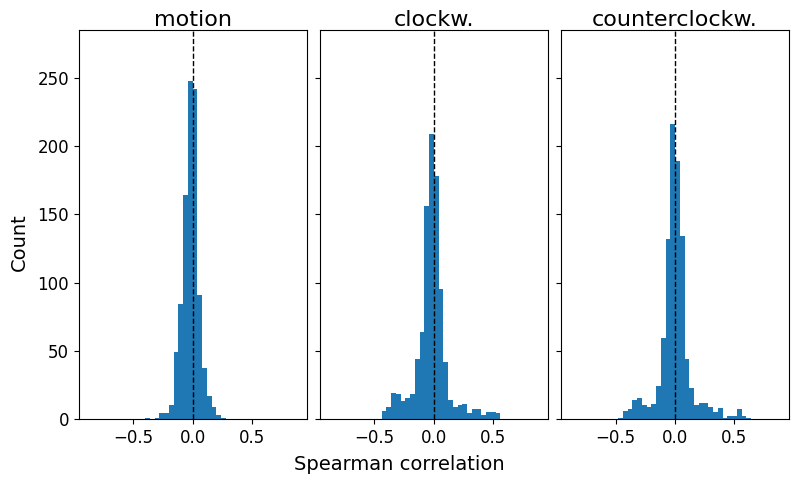

In [16]:
#| code-fold: true
fig, ax = plt.subplots(1,3, figsize=(20*ps.cm, 12*ps.cm), sharex=True, sharey=True, constrained_layout=True)
ax[0].hist(corr_motion, bins=40, range=(-0.8,0.8))
ax[0].axvline(0, lw=1, linestyle='dashed', c='k')
ax[1].hist(corr_clock, bins=40, range=(-0.8,0.8))
ax[1].axvline(0, lw=1, linestyle='dashed', c='k')
ax[2].hist(corr_cclock, bins=40, range=(-0.8,0.8))
ax[2].axvline(0, lw=1, linestyle='dashed', c='k')
ax[0].set_title("motion")
ax[1].set_title("clockw.")
ax[2].set_title("counterclockw.")
fig.supxlabel("Spearman correlation", fontsize=14)
fig.supylabel("Count", fontsize=14)

Since this does not look so promising, we'll include the contrasts in our regressors. If the contrast was low but the motion was on, we expect to see no cells reacting. But this condition is still included in our current regressors. This is fixed once we include contrasts.

## Finding contrast selective cells

To include contrast, we first need to calculate the achromatic contrast and the contrast for the red and green color channel seperately.
Instead of already combining contrast and motion, we first want to see the correlation between the contrasts and the calcium activity excluding motion.

In [26]:
# make empty lists for contrasts
red_contr = []
green_contr = []
acr_contr = []

for rgb1, rgb2 in zip(d.rgb_1, d.rgb_2):
    red_contr.append(abs(rgb1[0]-rgb2[0]))
    green_contr.append(abs(rgb1[1]-rgb2[1]))

red_contr = np.array(red_contr)
green_contr = np.array(green_contr)

# iterate across channels and append chromatic contrasts
# for rgb1, rgb2 in zip(d.rgb_1, d.rgb_2):
#     if rgb2[1] == 0:
#         red_contr.append(rgb1[0])
#     else:
#         red_contr.append(0)
#     if rgb1[0] == 0:
#         green_contr.append(rgb2[1])
#     else:
#         green_contr.append(0)
# green_contr = np.array(green_contr)
# red_contr = np.array(red_contr)


# make achromatic contrast as the difference between the sums of both stripes
acr_contr = np.array([abs(np.sum(x)-np.sum(y)) for x, y in zip(d.rgb_1, d.rgb_2)])

Now we correlate the contrasts with the calcium data.

In [27]:
corr_red = np.array([pearsonr(x, red_contr)[0] for x in d.active_mean_dffs])

corr_green = np.array([pearsonr(x, green_contr)[0] for x in d.active_mean_dffs])

corr_acr = np.array([pearsonr(x, acr_contr)[0] for x in d.active_mean_dffs])

Text(0.02, 0.5, 'Count')

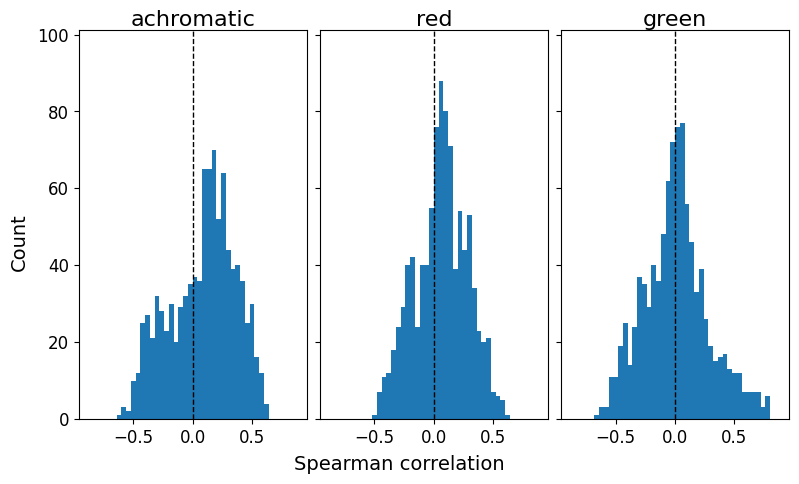

In [28]:
#| code-fold: true
fig, ax = plt.subplots(1,3, figsize=(20*ps.cm, 12*ps.cm), sharex=True, sharey=True, constrained_layout=True)
ax[0].hist(corr_acr, bins=40, range=(-0.8,0.8))
ax[0].axvline(0, lw=1, linestyle='dashed', c='k')
ax[1].hist(corr_red, bins=40, range=(-0.8,0.8))
ax[1].axvline(0, lw=1, linestyle='dashed', c='k')
ax[2].hist(corr_green, bins=40, range=(-0.8,0.8))
ax[2].axvline(0, lw=1, linestyle='dashed', c='k')
ax[0].set_title("achromatic")
ax[1].set_title("red")
ax[2].set_title("green")
fig.supxlabel("Spearman correlation", fontsize=14)
fig.supylabel("Count", fontsize=14)

## Finding motion selective cells by encoding contrast with motion

We see that some cells might correlate with achromatic contrast. Does this hold up when we include motion into the regressor? In order to find motion sensitive cells instead of just contrast sensitive cells, we need to encode the motion including the contrast so that the motions with low contrasts are not represented as strong stimuli.

Text(0.02, 0.5, 'Count')

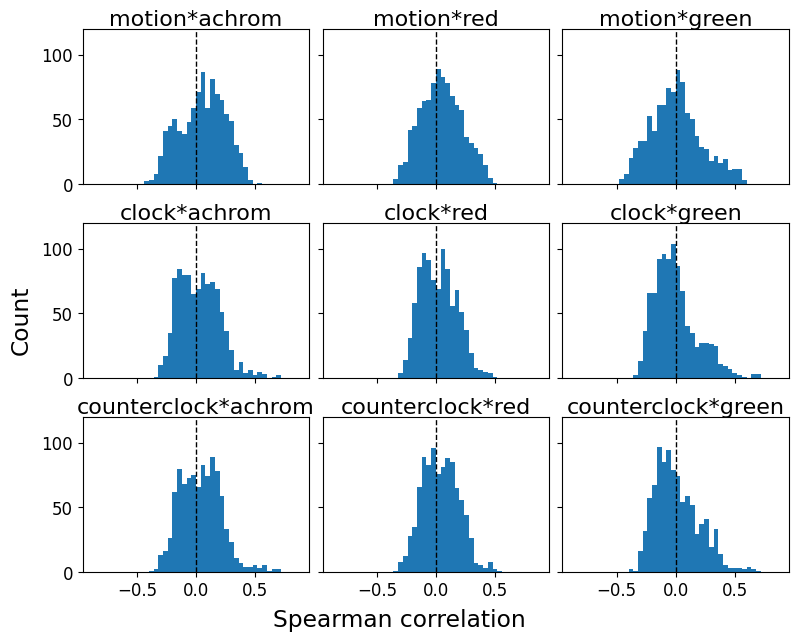

In [29]:
motions = [motion, clock, cclock]
motions_string = ["motion", "clock", "counterclock"]
contr = [acr_contr, red_contr, green_contr]
contr_string = ["achrom", "red", "green"]

fig, axs = plt.subplots(3,3, figsize=(20*ps.cm, 16*ps.cm), sharex=True, sharey=True, constrained_layout=True)

for i1, m in enumerate(motions):
  for i2, c in enumerate(contr):
    reg = c*m
    corr = np.array([pearsonr(x, reg)[0] for x in d.active_mean_dffs])
    title = motions_string[i1] + '*' + contr_string[i2]
    n, bins, patches = axs[i1, i2].hist(corr, bins=40, range=(-0.8,0.8))
    axs[i1, i2].axvline(0, lw=1, linestyle='dashed', c='k')
    axs[i1, i2].set_title(title)
fig.supxlabel('Spearman correlation')
fig.supylabel('Count')

## Removing low contrasts to reduce the effect of flickering

We still don't see clear correlations with the stimulus, which could be due to strong flickering of the video projector in the setup at low contrast levels. In a next step, we'll remove all stimulation phases with the 3 lowest contrast levels except 0 and redo our correlation analysis.

In [30]:
# make remove index
remove_red = [True if x == 0 or x > 0.5 else False for x in red_contr]
remove_green = [True if x == 0 or x > 0.5 else False for x in green_contr]
remove = [True if x and y else False for x,y in zip(remove_red, remove_green)]

Now that we have a boolean index of the data points that we still want to inlcude, we have to index all arrays that go into the correlation with this index.

We now have arrays that we can use to correlate with our calcium activity, i.e. the dffs for each ROI.

In [31]:
corr_motion = np.array([pearsonr(x[remove], motion[remove])[0] for x in d.active_mean_dffs])

corr_clock = np.array([pearsonr(x[remove], clock[remove])[0] for x in d.active_mean_dffs])

corr_cclock = np.array([pearsonr(x[remove], cclock[remove])[0] for x in d.active_mean_dffs])

Now we can plot the distribution of the correlation coefficients.

Text(0.02, 0.5, 'Count')

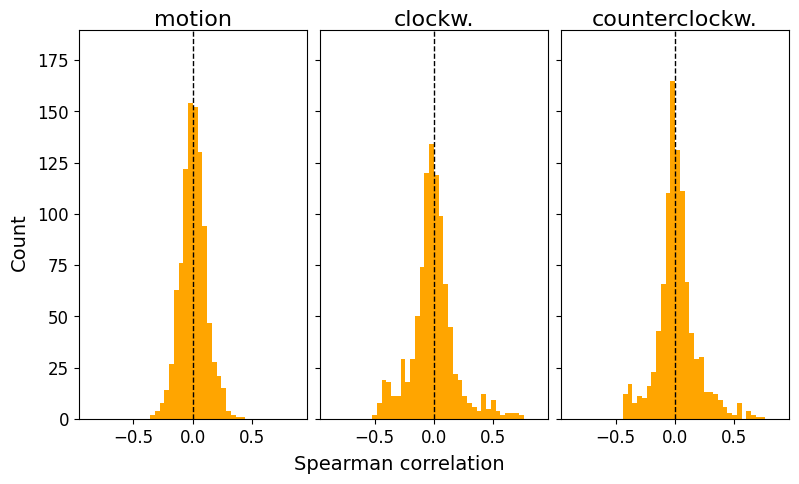

In [32]:
#| code-fold: true
fig, ax = plt.subplots(1,3, figsize=(20*ps.cm, 12*ps.cm), sharex=True, sharey=True, constrained_layout=True)
ax[0].hist(corr_motion, bins=40, range=(-0.8,0.8), facecolor='orange')
ax[0].axvline(0, lw=1, linestyle='dashed', c='k')
ax[1].hist(corr_clock, bins=40, range=(-0.8,0.8), facecolor='orange')
ax[1].axvline(0, lw=1, linestyle='dashed', c='k')
ax[2].hist(corr_cclock, bins=40, range=(-0.8,0.8), facecolor='orange')
ax[2].axvline(0, lw=1, linestyle='dashed', c='k')
ax[0].set_title("motion")
ax[1].set_title("clockw.")
ax[2].set_title("counterclockw.")
fig.supxlabel("Spearman correlation", fontsize=14)
fig.supylabel("Count", fontsize=14)

In [33]:
corr_red = np.array([pearsonr(x[remove], red_contr[remove])[0] for x in d.active_mean_dffs])

corr_green = np.array([pearsonr(x[remove], green_contr[remove])[0] for x in d.active_mean_dffs])

corr_acr = np.array([pearsonr(x[remove], acr_contr[remove])[0] for x in d.active_mean_dffs])

First we plot the correlation between the contrasts.

Text(0.02, 0.5, 'Count')

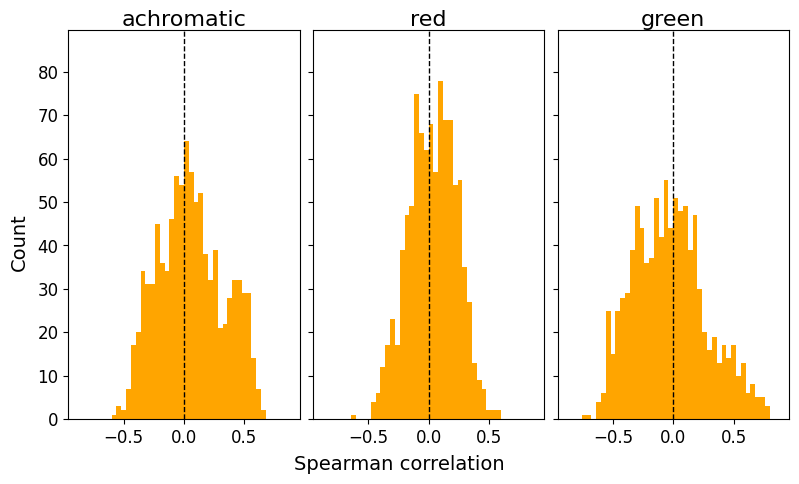

In [34]:
#| code-fold: true
fig, ax = plt.subplots(1,3, figsize=(20*ps.cm, 12*ps.cm), sharex=True, sharey=True, constrained_layout=True)
ax[0].hist(corr_acr, bins=40, range=(-0.8,0.8), facecolor='orange')
ax[0].axvline(0, lw=1, linestyle='dashed', c='k')
ax[1].hist(corr_red, bins=40, range=(-0.8,0.8), facecolor='orange')
ax[1].axvline(0, lw=1, linestyle='dashed', c='k')
ax[2].hist(corr_green, bins=40, range=(-0.8,0.8), facecolor='orange')
ax[2].axvline(0, lw=1, linestyle='dashed', c='k')
ax[0].set_title("achromatic")
ax[1].set_title("red")
ax[2].set_title("green")
fig.supxlabel("Spearman correlation", fontsize=14)
fig.supylabel("Count", fontsize=14)

Now we combine motions and contrast levels. We would expect high correlation coefficients for motion directions and achromatic contrasts.

Text(0.02, 0.5, 'Count')

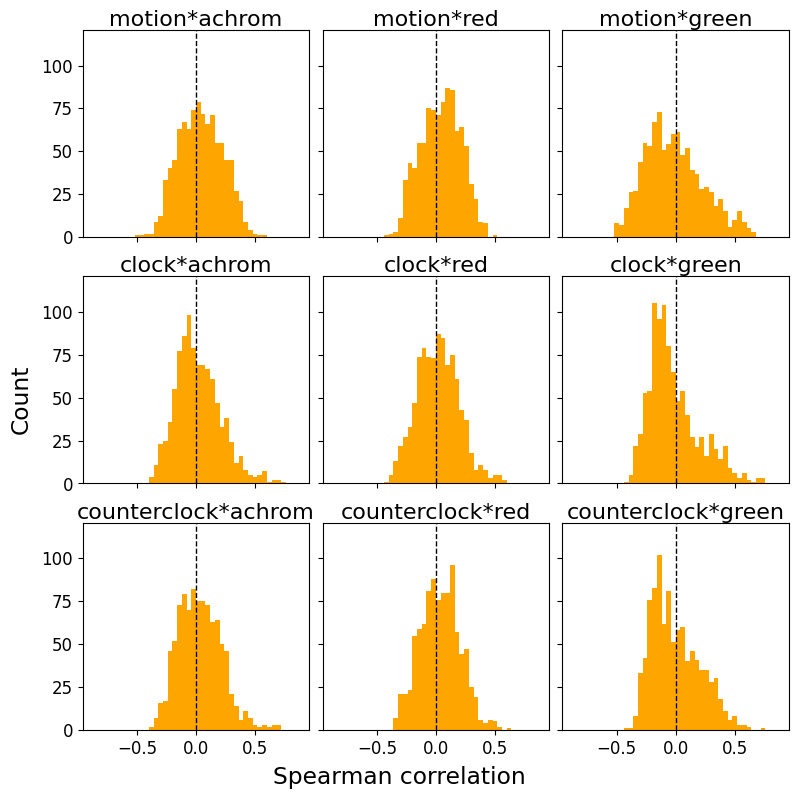

In [35]:
motions = [motion[remove], clock[remove], cclock[remove]]
motions_string = ["motion", "clock", "counterclock"]
contr = [acr_contr[remove], red_contr[remove], green_contr[remove]]
contr_string = ["achrom", "red", "green"]

fig, axs = plt.subplots(3,3, figsize=(20*ps.cm, 20*ps.cm), sharex=True, sharey=True, constrained_layout=True)

for i1, m in enumerate(motions):
  for i2, c in enumerate(contr):
    reg = c*m
    corr = np.array([pearsonr(x[remove], reg)[0] for x in d.active_mean_dffs])
    title = motions_string[i1] + '*' + contr_string[i2]
    n, bins, patches = axs[i1, i2].hist(corr, bins=40, range=(-0.8,0.8), facecolor='orange')
    axs[i1, i2].set_title(title)
    axs[i1, i2].axvline(0, lw=1, linestyle='dashed', c='k')
    # axs[i1, i2].set_ylim(0,1/3*np.max(n))
fig.supxlabel('Spearman correlation')
fig.supylabel('Count')

## Plot the stimulus and ROI for thresholded correlation coefficient

The distributions show peaks at positive but also negative correlation coefficients. We expected just the positive peaks. To verify that the peaks are actually reflecting the data, we will now plot a few of the dffs that are strongly positively and strongly negatively correlated with the stimulus. Since removing the low contrast (strong flickering) data did not change anything, we continue to work on the full dataset including the stimuli with flickering.

First, we'll build two of the stimuli regressors we already used in plotting the correlation histogram matrix. Then we correlate the active dffs with the regressor and choose a correlation coefficient as a threshold. In the plotting loop, we then choose the 5 dff traces with the highest correlation coefficient and plot them on top of the regressor.

In [36]:
# build stimulus
clock_acr = np.array(clock * acr_contr)
cclock_acr = np.array(cclock * acr_contr)

# correlate
corr_clock_acr = np.array([pearsonr(clock_acr, x)[0] for x in d.active_mean_dffs])
corr_cclock_acr = np.array([pearsonr(cclock_acr, x)[0] for x in d.active_mean_dffs])

# make index vector
index = np.arange(len(corr_clock_acr))

# make threshold
thresh = 0.4

# use threshold to get index
index_clock_acr = index[corr_clock_acr > thresh]
index_cclock_acr = index[corr_cclock_acr > thresh]

# use the index to get the dff data
dffs_clock_acr = d.active_mean_dffs[index_clock_acr, :]
dffs_cclock_acr = d.active_mean_dffs[index_cclock_acr, :]

Text(0.02, 0.5, 'Norm. activity')

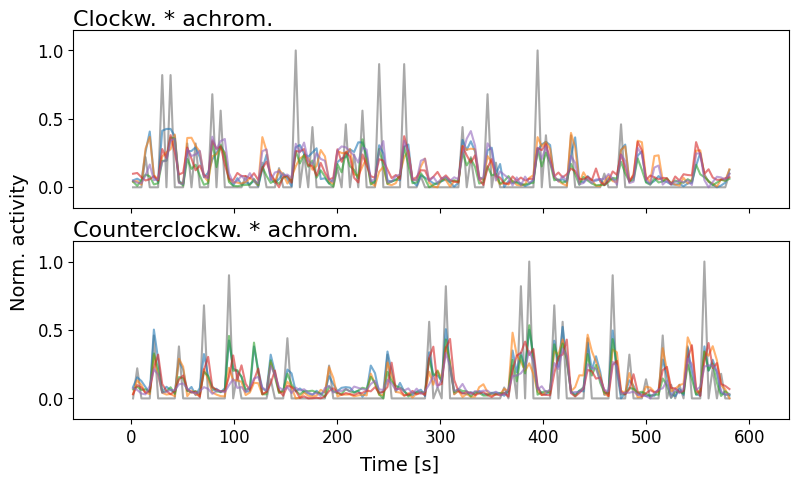

In [37]:
#| code-fold: true
# plot them
idx = np.arange(d.inx_mean[0][1]+1)
fig, ax = plt.subplots(2,1, figsize=(20*ps.cm, 12*ps.cm), constrained_layout=True, sharex=True, sharey=True)

ax[0].set_title('Clockw. * achrom.', loc='left')
ax[0].plot(d.mean_times[idx], clock_acr[idx], c='darkgray', label='stimulus')
for i in range(5):
    clock_acr_dff = dffs_clock_acr[i]
    ax[0].plot(d.mean_times[idx], clock_acr_dff[idx]-clock_acr_dff[idx].min(), label = 'dff', alpha = 0.6)

ax[1].set_title('Counterclockw. * achrom.', loc='left')
ax[1].plot(d.mean_times[idx], cclock_acr[idx], c='darkgray', label='stimulus')
for i in range(5):
    cclock_acr_dff = dffs_cclock_acr[i]
    ax[1].plot(d.mean_times[idx], cclock_acr_dff[idx]-cclock_acr_dff[idx].min(), label = 'dff', alpha = 0.6)

# ax[0].legend()
fig.supxlabel('Time [s]', fontsize=14)
fig.supylabel('Norm. activity', fontsize=14)

Now we try the same for a negative correlation threshold. The same routine is repeated just with a negative correlation coefficient threshold. In this case the threshold was smaller because there were fewer dffs that were strongly negatively correlated to the regressor.

In [38]:
# make threshold
thresh = -0.25

# use threshold to get index
index_clock_acr = index[corr_clock_acr < thresh]
index_cclock_acr = index[corr_cclock_acr < thresh]

# use the index to get the dff data
dffs_clock_acr = d.active_mean_dffs[index_clock_acr, :]
dffs_cclock_acr = d.active_mean_dffs[index_cclock_acr, :]

Text(0.02, 0.5, 'Norm. activity')

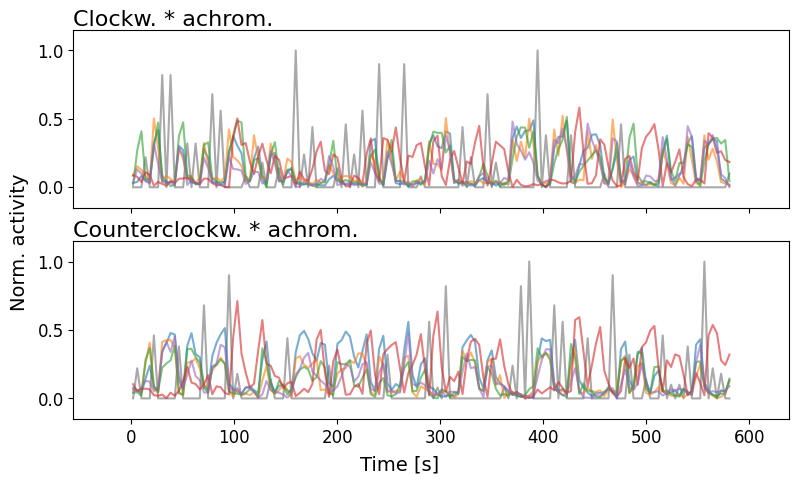

In [39]:
#| code-fold: true
# plot them
idx = np.arange(d.inx_mean[0][1]+1)
fig, ax = plt.subplots(2,1, figsize=(20*ps.cm, 12*ps.cm), constrained_layout=True, sharex=True, sharey=True)

ax[0].set_title('Clockw. * achrom.', loc='left')
ax[0].plot(d.mean_times[idx], clock_acr[idx], c='darkgray', label='stimulus')
for i in range(5):
    clock_acr_dff = dffs_clock_acr[i]
    ax[0].plot(d.mean_times[idx], clock_acr_dff[idx]-clock_acr_dff[idx].min(), label = 'dff', alpha = 0.6)

ax[1].set_title('Counterclockw. * achrom.', loc='left')
ax[1].plot(d.mean_times[idx], cclock_acr[idx], c='darkgray', label='stimulus')
for i in range(5):
    cclock_acr_dff = dffs_cclock_acr[i]
    ax[1].plot(d.mean_times[idx], cclock_acr_dff[idx]-cclock_acr_dff[idx].min(), label = 'dff', alpha = 0.6)

# ax[0].legend()
fig.supxlabel('Time [s]', fontsize=14)
fig.supylabel('Norm. activity', fontsize=14)

## Extracting motion selectie units

We have now explored the data and know that we have units in our dataset that respond to our stimulus. In a next step, we want to extract these cells while staying stimulus agnosting. The test stimulus were the different contrast levels. In order to exclude this in our selected units, we will use the regressor that only includes motion direction to correlate, and subsequenctly threshold, to get the dffs of the units for further analysis.

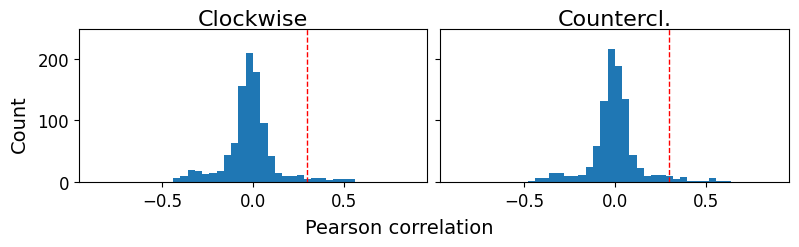

In [40]:
# compute corrs
corr_clock = np.array([pearsonr(x, clock)[0] for x in d.active_mean_dffs])
corr_cclock = np.array([pearsonr(x, cclock)[0] for x in d.active_mean_dffs])

thresh = 0.3

# plot
fig, ax = plt.subplots(1,2,figsize=(20*ps.cm, 6*ps.cm), sharex=True, sharey = True, constrained_layout = True)
ax[0].hist(corr_clock, bins=40, range=(-0.8,0.8))
ax[0].axvline(thresh, lw=1, c='r', ls='dashed')
ax[1].hist(corr_cclock, bins=40, range=(-0.8,0.8))
ax[1].axvline(thresh, lw=1, c='r', ls='dashed')
ax[0].set_title('Clockwise')
ax[1].set_title('Countercl.')
fig.supxlabel('Pearson correlation', fontsize=14)
fig.supylabel('Count', fontsize=14)

# threshold rois
class selective_rois:
    def __init__(self, all_rois, corrs, thresh):

        # get active rois
        self.__all_dffs = all_rois.active_mean_dffs 
        self.__all_rois = all_rois.active_mean_rois
        self.__all_recs = all_rois.active_mean_recs
        self.__all_corrs = corrs
        self.thresh = thresh
        
        # do checks
        if len(corr) != len(self.__all_dffs):
            raise ValueError('The correlations do not match the active dffs!')
        
        if (thresh > 0) & (len(self.__all_corrs[self.__all_corrs>thresh]) == 0):
            raise ValueError('The threshold is too large!')

        if (thresh < 0) & (len(self.__all_corrs[self.__all_corrs<thresh]) == 0):
            raise ValueError('The threshold is too small!')

        # get selective dff data
        self.dffs = self.__all_dffs[self.__all_corrs > self.thresh]
        self.rois = self.__all_rois[self.__all_corrs > self.thresh]
        self.recs = self.__all_recs[self.__all_corrs > self.thresh]
        self.corrs = self.__all_corrs[self.__all_corrs > self.thresh]

# get the data
dc = selective_rois(d, corr_clock, thresh)
dcc = selective_rois(d, corr_cclock, thresh)

Now lets first take a look at the responses of both direction selective cells to different levels of achromatic contrast.

In [41]:
class phase_activity:
    def __init__(self, selective_rois, stim):

        self.__rois = selective_rois
        self.__stim = stim
        self.__cat_index = np.arange(len(self.__stim))
        self.cats = np.unique(self.__stim[~np.isnan(self.__stim)])
        self.dffs = []
        self.mean_dffs = []
        self.rois = self.__rois.rois
        self.recs = self.__rois.recs
        
        for i in self.cats:
            idx = self.__cat_index[self.__stim == i]
            cat_dffs = self.__rois.dffs[:,idx]
            mean_dffs = np.mean(cat_dffs, axis=1)
            self.dffs.append(cat_dffs)
            self.mean_dffs.append(mean_dffs)

# build stim
clock_stim = np.array(clock, dtype=float)
cclock_stim = np.array(cclock, dtype=float)

clock_stim[clock_stim == 0] = np.nan
cclock_stim[cclock_stim == 0] = np.nan

acr_clock_stim = clock_stim * acr_contr
acr_cclock_stim = cclock_stim * acr_contr

acr_clock_activity = phase_activity(dc, acr_clock_stim)
acr_cclock_activity = phase_activity(dcc, acr_cclock_stim)

Text(0.02, 0.5, 'Mean dff')

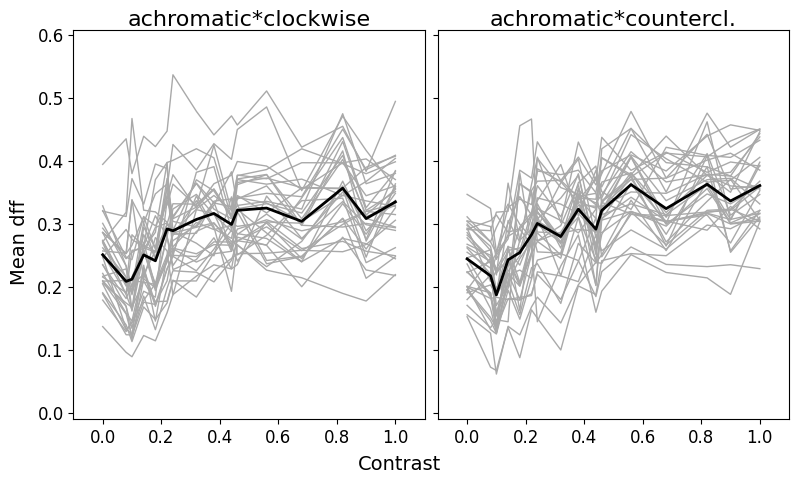

In [42]:
#| code-fold: true
fig, ax = plt.subplots(1,2,figsize=(20*ps.cm, 12*ps.cm),sharex=True,sharey=True, constrained_layout=True)
ax[0].plot(acr_clock_activity.cats, acr_clock_activity.mean_dffs, c='darkgray', lw=1,)
ax[1].plot(acr_cclock_activity.cats, acr_cclock_activity.mean_dffs, c='darkgray', lw=1)
ax[0].plot(acr_clock_activity.cats, np.mean(acr_clock_activity.mean_dffs, axis=1), lw=2, c='k')
ax[1].plot(acr_cclock_activity.cats, np.mean(acr_cclock_activity.mean_dffs, axis=1), lw=2, c='k')
ax[0].set_title('achromatic*clockwise')
ax[1].set_title('achromatic*countercl.')
fig.supxlabel('Contrast', fontsize=14)
fig.supylabel('Mean dff', fontsize=14)

Both direction selective cell types increase their activity with increasing absolute intensity contrast. Now lets see how red and green contrast influence the activity together.

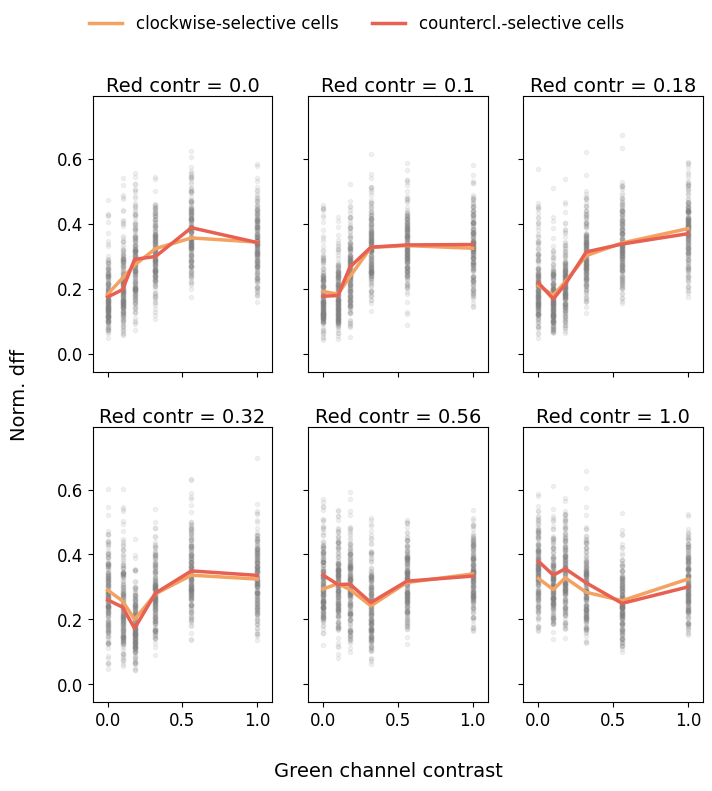

In [74]:
class rg_activity:
    def __init__(self, selective_rois, contr1, contr2):

        self.__rois = selective_rois
        self.__contr1 = contr1
        self.__contr2 = contr2
        self.__index = np.arange(len(self.__contr1))
        self.contr1 = np.unique(self.__contr1[~np.isnan(self.__contr1)])
        self.contr2 = np.unique(self.__contr2[~np.isnan(self.__contr2)])
        self.dffs = []
        self.mean_dffs = []
        self.contr1_index = []
        self.contr2_index = []
        self.rois = self.__rois.rois
        self.recs = self.__rois.recs
        
        for c1 in self.contr1:

            self.contr1_index.append(c1)
            idx = self.__index[self.__contr1 == c1]
            cat_dffs = self.__rois.dffs[:,idx]
            # mean_dffs = np.mean(cat_dffs, axis=1)
            self.contr2_index.append(self.__contr2[idx])
            self.dffs.append(cat_dffs)
            # self.mean_dffs.append(mean_dffs)

        self.mean_dffs = np.array(self.mean_dffs)
        self.contr1_index = np.array(self.contr1_index)
        self.contr2_index = np.array(self.contr2_index)

red_clock_stim = red_contr*clock_stim
green_clock_stim = green_contr*clock_stim

red_cclock_stim = red_contr*cclock_stim
green_cclock_stim = green_contr*cclock_stim

rg_clock_data = rg_activity(dc, red_clock_stim, green_clock_stim)
rg_cclock_data = rg_activity(dcc, red_cclock_stim, green_cclock_stim)

fig, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=(20*ps.cm, 20*ps.cm))
ax = fs.flatten(ax)

colors = [ps.orange, ps.red]
labels = ['clockwise-selective cells', 'countercl.-selective cells']
for lab, color, rg_clock in zip(labels, colors, [rg_clock_data, rg_cclock_data]):
    for i1, rds in enumerate(rg_clock.contr1):
        dffs = []
        contr = []
        for dff in np.array(rg_clock.dffs)[rg_clock.contr1 == rds]:
            for i in range(len(dff[:,0])):
                
                # the data
                roi_dff = dff[i,:]
                contrsts2 = np.array(rg_clock.contr2_index)[rg_clock.contr1 == rds][0]

                # sort the data
                sort_roi_dff = roi_dff[np.argsort(contrsts2)]
                sort_contrsts2 = contrsts2[np.argsort(contrsts2)]

                dffs.append(sort_roi_dff)
                contr.append(sort_contrsts2)

                ax[i1].scatter(
                    sort_contrsts2, 
                    sort_roi_dff, 
                    color='grey', 
                    marker='.', 
                    # edgecolor='gray', 
                    alpha = 0.1
                )

        # compute means for each category
        contrs = np.unique(fs.flatten(contr))
        meandff = []
        for c2 in contrs:
            meandff.append(np.mean(np.array(fs.flatten(dffs))[fs.flatten(contr) == c2]))

        ax[i1].plot(contrs, meandff, label=lab, c=color, lw=2.5)
        ax[i1].set_title(f"Red contr = {np.round(rds,2)}", fontsize=14)

fig.supxlabel('Green channel contrast', fontsize=14)
fig.supylabel('Norm. dff', fontsize=14)
handles, labels = ax[i1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)